DAA 전략은 폭락 신호를 미리 주는 카나리아 자산군을 이용해 VAA 전략을 개선한 전략입니다. VAA와 비슷한 수준으로 하락 폭을 낮추면서 방어 자산에 머무는 시간은 줄여보려는 시도를 합니다. VAA 전략은 논문에 따르면 1970년부터 테스트할 경우 60% 기간에서 방어 자산에 머무른다 합니다. 방어 자산은 단기 혹은 중기 채권이니 하락 폭이 낮은 것이 당연합니다. 그런데, 금리가 계속 낮아져서 더 내려갈 곳이 없어보이니 방어 자산인 채권 쪽에 머무는 기간이 짧을수록 좋을 것이고, DAA 전략은 카나리아 자산군을 가지고 그 시도를 합니다.

공격 자산으로 SPY (S&P 500), IWM (Russell 2000), QQQ (NASDAQ 100), VGK (Europe), EWJ (Japan), VWO (Emerging), VNQ (US REITs), GSG (Commodities), GLD (Gold), TLT (US 20+ Year Treasury), HYG (High Yield), LQD (Investment Grade Corporate Bond)를 사용합니다. 방어 자산으로 SHY (US 1-3 Year Treasury), IEF (US 7-10 Year Treasury), UST (Leveraged US 7-10 Year Treasury)를 사용합니다. 카나리아로는 VWO (Emerging), BND (US Bond)를 사용합니다. 

방어 자산에서 레버리지 채권을 사용한다는 것과 카나리아의 작동 원리에 대한 명확한 설명이 없는 것이 상당히 마음에 걸리고 과최적화 요소가 있다는 생각이 듭니다. VAA는 그래도 직접 사용하려면 할 수도 있다는 생각이 들었는데, DAA는 과최적화 문제와 설명되지 않는 전략의 원리 때문에 전략의 성과가 괜찮을 경우 카나리아의 경고 기능만 참고하는 것이 더 나을 것 같습니다. 

보유 자산 개수와 유니버스 구성에 따라 여러 가지 버전을 소개하고 있지만, 가장 간단하게 구현하기 위해서 12개 자산 중 2개를 보유하고, 카나리아 중 1개라도 모멘텀이 음수가 되면 방어 자산으로 전환하는 것으로 하겠습니다.

In [1]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime, timedelta
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
import seaborn
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [3]:
# UST starts: 2010-02-02
start = datetime(2010,2,2)
end = datetime(2021,5,31)

tickers = ['SPY','IWM','QQQ','VGK','EWJ','VWO','VNQ','GSG','GLD','TLT','HYG','LQD','SHY','IEF','UST','BND']

def get_price_data(tickers):
    df_asset = pd.DataFrame(columns=tickers)
    
    for ticker in tickers:
        df_asset[ticker] = pdr.get_data_yahoo(ticker, start, end)['Adj Close']  
         
    return df_asset

In [4]:
df_asset = get_price_data(tickers)
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,HYG,LQD,SHY,IEF,UST,BND
Date,,,,,,,,,,,,,,,,
2010-02-01,87.369308,51.841839,38.692165,31.332651,33.213573,29.669722,27.528179,29.760000,108.349998,67.162880,44.366608,69.872231,75.673912,71.984238,NaN,57.548431
2010-02-02,88.426773,52.412945,39.040977,31.816971,33.848446,29.813013,27.905521,30.540001,109.129997,67.354454,44.500778,70.092743,75.682968,72.104065,31.840761,57.584766
2010-02-03,87.986176,52.063454,39.255638,31.420099,33.514305,29.730051,27.451429,30.430000,108.699997,66.573395,44.727821,70.019241,75.628647,71.760498,31.540672,57.548431
2010-02-04,85.270409,50.324612,38.119724,29.879702,32.879444,28.372511,26.434471,29.180000,104.370003,67.627098,44.093166,70.012527,75.737381,72.351776,32.033367,57.657291
2010-02-05,85.446671,50.520645,38.441723,29.603916,32.812611,28.319714,26.920568,28.610001,104.680000,67.774467,43.835106,69.798599,75.855225,72.583481,32.243862,57.751656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,419.170013,221.067902,332.510010,68.739998,67.730568,52.560001,99.099998,15.320000,176.350006,137.981369,86.918900,131.323257,86.288010,114.241051,66.940002,85.066093
2021-05-25,418.239990,218.931122,332.970001,68.769997,67.571732,53.110001,99.070000,15.230000,177.949997,139.259537,86.928871,131.812302,86.288010,114.660759,67.480003,85.285744
2021-05-26,419.070007,223.014999,334.130005,68.570000,67.720634,53.500000,99.510002,15.260000,177.639999,139.019882,86.958763,131.742432,86.307999,114.530853,67.320000,85.255798


모멘텀 측정은 VAA와 같은 방식입니다.

In [5]:
def get_momentum(x):
    temp = [0 for _ in range(len(x.index))]
    momentum = pd.Series(temp, index=x.index)
    
    try:
        before_1m = df_asset[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1]
        before_3m = df_asset[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1]
        before_6m = df_asset[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1]
        before_12m = df_asset[x.name-timedelta(days=370):x.name-timedelta(days=365)].iloc[-1]
        momentum = (x/before_1m - 1) * 12 + (x/before_3m - 1) * 4 + (x/before_6m - 1) * 2 + (x/before_12m - 1) * 1
        
    except:
        pass
    
    return momentum

In [6]:
momentum_col = [col + '_m' for col in df_asset.columns]
df_asset[momentum_col] = df_asset.apply(lambda x: get_momentum(x), axis=1)
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,VNQ_m,GSG_m,GLD_m,TLT_m,HYG_m,LQD_m,SHY_m,IEF_m,UST_m,BND_m
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,87.369308,51.841839,38.692165,31.332651,33.213573,29.669722,27.528179,29.760000,108.349998,67.162880,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-02,88.426773,52.412945,39.040977,31.816971,33.848446,29.813013,27.905521,30.540001,109.129997,67.354454,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-03,87.986176,52.063454,39.255638,31.420099,33.514305,29.730051,27.451429,30.430000,108.699997,66.573395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-04,85.270409,50.324612,38.119724,29.879702,32.879444,28.372511,26.434471,29.180000,104.370003,67.627098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-05,85.446671,50.520645,38.441723,29.603916,32.812611,28.319714,26.920568,28.610001,104.680000,67.774467,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,419.170013,221.067902,332.510010,68.739998,67.730568,52.560001,99.099998,15.320000,176.350006,137.981369,...,1.358082,1.935591,1.049765,-0.628452,0.241144,-0.017866,0.009609,-0.220735,-0.475886,-0.083240
2021-05-25,418.239990,218.931122,332.970001,68.769997,67.571732,53.110001,99.070000,15.230000,177.949997,139.259537,...,1.318387,1.754967,1.234661,-0.432183,0.239206,0.046774,0.010535,-0.146308,-0.316347,-0.032072
2021-05-26,419.070007,223.014999,334.130005,68.570000,67.720634,53.500000,99.510002,15.260000,177.639999,139.019882,...,1.418435,1.703291,1.283438,-0.386543,0.278156,0.101121,0.023759,-0.104925,-0.248058,0.001229


12개월 모멘텀 때문에 맨 앞 1년은 사용 못 합니다. 2011년 2월부터로 합니다.

In [8]:
df_asset = df_asset.loc[df_asset.index >= '2011-02-01']
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,VNQ_m,GSG_m,GLD_m,TLT_m,HYG_m,LQD_m,SHY_m,IEF_m,UST_m,BND_m
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-01,106.793480,68.853111,51.499950,36.662815,37.782318,36.439194,38.026897,35.169998,130.800003,69.387650,...,1.239551,1.309876,-0.265052,-0.834173,0.637448,-0.017324,0.006136,-0.236705,NaN,-0.050819
2011-02-02,106.589310,68.594086,51.418713,36.472588,38.155067,36.155289,38.026897,35.430000,130.449997,69.403015,...,0.910057,1.255910,-0.411221,-0.793767,0.593642,-0.151748,-0.003878,-0.288898,-0.672006,-0.075985
2011-02-03,106.826195,68.835823,51.508987,36.338745,38.460037,36.124603,38.133057,35.189999,132.199997,68.827675,...,1.183307,1.375842,0.110225,-0.882831,0.536989,-0.199129,-0.015095,-0.402696,-0.686325,-0.124329
2011-02-04,107.128410,68.956688,51.797848,36.268276,38.460037,36.109249,37.854385,34.820000,131.660004,68.129547,...,1.044275,1.060971,0.115575,-0.824964,0.608110,-0.169236,-0.010958,-0.397768,-0.870382,-0.138112
2011-02-07,107.798210,69.638779,52.041588,36.465534,38.426144,36.009502,38.225952,34.540001,131.679993,68.482460,...,1.577599,1.271221,0.216314,-0.801310,0.740733,-0.199642,-0.044757,-0.538223,-1.155269,-0.176788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,419.170013,221.067902,332.510010,68.739998,67.730568,52.560001,99.099998,15.320000,176.350006,137.981369,...,1.358082,1.935591,1.049765,-0.628452,0.241144,-0.017866,0.009609,-0.220735,-0.475886,-0.083240
2021-05-25,418.239990,218.931122,332.970001,68.769997,67.571732,53.110001,99.070000,15.230000,177.949997,139.259537,...,1.318387,1.754967,1.234661,-0.432183,0.239206,0.046774,0.010535,-0.146308,-0.316347,-0.032072
2021-05-26,419.070007,223.014999,334.130005,68.570000,67.720634,53.500000,99.510002,15.260000,177.639999,139.019882,...,1.418435,1.703291,1.283438,-0.386543,0.278156,0.101121,0.023759,-0.104925,-0.248058,0.001229


월말 리밸런싱이니 월말 데이터만 남깁니다.

In [9]:
df_asset = df_asset.resample(rule='M').last()
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,VNQ_m,GSG_m,GLD_m,TLT_m,HYG_m,LQD_m,SHY_m,IEF_m,UST_m,BND_m
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-28,108.762093,71.028740,52.149918,36.979843,39.069965,35.610512,39.718895,36.090000,137.660004,70.883598,...,1.995436,1.899666,1.266375,-0.276685,0.816563,0.190184,-0.008232,-0.232592,-0.562941,0.028218
2011-03-31,108.775154,72.820862,51.916138,36.599407,34.969822,37.559448,39.079159,37.349998,139.860001,70.904404,...,0.940898,1.158847,0.471898,-0.226286,0.409223,-0.000445,-0.018847,-0.070018,-0.072899,0.025793
2011-04-30,111.925438,74.741508,53.407722,39.642902,35.681419,38.825504,41.324863,38.939999,152.369995,72.562889,...,1.704354,1.979601,2.494927,0.369483,0.588568,0.468896,0.086754,0.254752,0.491686,0.277425
2011-05-31,110.670242,73.400536,52.756824,38.515682,34.800400,37.682228,41.892963,36.270000,149.639999,75.046593,...,1.200952,-0.398602,0.535228,0.803858,0.409638,0.493483,0.105261,0.597047,1.151202,0.358044
2011-06-30,108.803261,71.635582,51.688271,37.712528,35.650742,37.306240,40.510811,34.110001,146.000000,73.303192,...,0.289141,-0.874243,0.208330,-0.161457,0.233109,0.139563,0.059275,0.187276,0.432305,0.126754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,368.861908,204.866409,314.163208,59.444050,66.499634,51.613457,84.466141,12.910000,172.610001,150.995331,...,0.697270,1.933817,-0.400905,-0.692182,0.292503,-0.084930,0.031092,-0.165833,-0.372042,-0.039657
2021-02-28,379.118286,217.573395,313.743744,60.977448,67.720634,52.422413,87.359230,14.240000,161.809998,142.338852,...,0.743281,2.643653,-1.081718,-1.489638,0.164813,-0.427842,0.016124,-0.560360,-1.158781,-0.296834
2021-03-31,396.329987,220.608597,319.130005,63.000000,68.018433,52.049999,91.860001,13.970000,159.960007,134.872787,...,1.573881,1.617859,-0.656969,-1.527842,0.344308,-0.377560,-0.008304,-0.702032,-1.381368,-0.324972


공격 자산 중 모멘텀이 가장 좋은 2개를 고릅니다. 카나리아 자산 중 1개라도 모멘텀이 음수면 방어 자산 중 모멘텀이 가장 좋은 자산으로 갑니다.

In [12]:
def select_asset(x):
    selected_asset = pd.Series([0,0,0,0], index=['ASSET1','PRICE1','ASSET2','PRICE2'])
    momentum1 = None
    momentum2 = None
    
    # 모든 카나라아 자산 > 0
    if x['VWO_m'] > 0 and x['BND_m'] > 0:
        # momentum_col = [col + '_m' for col in df_asset.columns]
        selected_momentum = x[momentum_col].sort_values(ascending=False)
        momentum1 = selected_momentum[0]
        momentum2 = selected_momentum[1]
        
        selected_asset['ASSET1'] = x[x==momentum1].index[0][:3]
        selected_asset['PRICE1'] = x[selected_asset['ASSET1']]
        selected_asset['ASSET2'] = x[x==momentum2].index[0][:3]
        selected_asset['PRICE2'] = x[selected_asset['ASSET2']]

    # 카나리아 자산 중 1개라도 < 0
    else:
        selected_momentum = max(x['SHY_m'], x['IEF_m'], x['UST_m'])
    
        # 이 경우 ASSET1, ASSET2는 같음
        selected_asset['ASSET1'] = x[x==selected_momentum].index[0][:3]
        selected_asset['PRICE1'] = x[selected_asset['ASSET1']]
        selected_asset['ASSET2'] = x[x==selected_momentum].index[0][:3]
        selected_asset['PRICE2'] = x[selected_asset['ASSET2']]
    
    return selected_asset

In [13]:
df_asset[['ASSET1','PRICE1','ASSET2','PRICE2']] = df_asset.apply(lambda x: select_asset(x), axis=1) 
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,HYG_m,LQD_m,SHY_m,IEF_m,UST_m,BND_m,ASSET1,PRICE1,ASSET2,PRICE2
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-28,108.762093,71.028740,52.149918,36.979843,39.069965,35.610512,39.718895,36.090000,137.660004,70.883598,...,0.816563,0.190184,-0.008232,-0.232592,-0.562941,0.028218,IWM,71.028740,VNQ,39.718895
2011-03-31,108.775154,72.820862,51.916138,36.599407,34.969822,37.559448,39.079159,37.349998,139.860001,70.904404,...,0.409223,-0.000445,-0.018847,-0.070018,-0.072899,0.025793,IWM,72.820862,VWO,37.559448
2011-04-30,111.925438,74.741508,53.407722,39.642902,35.681419,38.825504,41.324863,38.939999,152.369995,72.562889,...,0.588568,0.468896,0.086754,0.254752,0.491686,0.277425,GLD,152.369995,VGK,39.642902
2011-05-31,110.670242,73.400536,52.756824,38.515682,34.800400,37.682228,41.892963,36.270000,149.639999,75.046593,...,0.409638,0.493483,0.105261,0.597047,1.151202,0.358044,VNQ,41.892963,UST,39.013939
2011-06-30,108.803261,71.635582,51.688271,37.712528,35.650742,37.306240,40.510811,34.110001,146.000000,73.303192,...,0.233109,0.139563,0.059275,0.187276,0.432305,0.126754,EWJ,35.650742,UST,38.740704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,368.861908,204.866409,314.163208,59.444050,66.499634,51.613457,84.466141,12.910000,172.610001,150.995331,...,0.292503,-0.084930,0.031092,-0.165833,-0.372042,-0.039657,SHY,86.304970,SHY,86.304970
2021-02-28,379.118286,217.573395,313.743744,60.977448,67.720634,52.422413,87.359230,14.240000,161.809998,142.338852,...,0.164813,-0.427842,0.016124,-0.560360,-1.158781,-0.296834,SHY,86.254997,SHY,86.254997
2021-03-31,396.329987,220.608597,319.130005,63.000000,68.018433,52.049999,91.860001,13.970000,159.960007,134.872787,...,0.344308,-0.377560,-0.008304,-0.702032,-1.381368,-0.324972,SHY,86.207031,SHY,86.207031


각각의 수익률을 계산합니다.

In [14]:
return_col = [ticker + '_r' for ticker in tickers]
df_asset[return_col] = df_asset[tickers].pct_change()
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,VNQ_r,GSG_r,GLD_r,TLT_r,HYG_r,LQD_r,SHY_r,IEF_r,UST_r,BND_r
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-28,108.762093,71.028740,52.149918,36.979843,39.069965,35.610512,39.718895,36.090000,137.660004,70.883598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-31,108.775154,72.820862,51.916138,36.599407,34.969822,37.559448,39.079159,37.349998,139.860001,70.904404,...,-0.016107,0.034913,0.015981,0.000294,0.000425,-0.005405,-0.001299,-0.001545,0.002805,-0.001472
2011-04-30,111.925438,74.741508,53.407722,39.642902,35.681419,38.825504,41.324863,38.939999,152.369995,72.562889,...,0.057466,0.042570,0.089447,0.023390,0.015975,0.025044,0.005342,0.018413,0.031219,0.014638
2011-05-31,110.670242,73.400536,52.756824,38.515682,34.800400,37.682228,41.892963,36.270000,149.639999,75.046593,...,0.013747,-0.068567,-0.017917,0.034228,0.001333,0.012694,0.003639,0.025056,0.050537,0.011803
2011-06-30,108.803261,71.635582,51.688271,37.712528,35.650742,37.306240,40.510811,34.110001,146.000000,73.303192,...,-0.032992,-0.059553,-0.024325,-0.023231,-0.005706,-0.007972,-0.000047,-0.005044,-0.007004,-0.003756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,368.861908,204.866409,314.163208,59.444050,66.499634,51.613457,84.466141,12.910000,172.610001,150.995331,...,0.000353,0.047040,-0.032238,-0.036328,-0.003780,-0.018316,0.000232,-0.010921,-0.022261,-0.008618
2021-02-28,379.118286,217.573395,313.743744,60.977448,67.720634,52.422413,87.359230,14.240000,161.809998,142.338852,...,0.034251,0.103021,-0.062569,-0.057329,-0.002447,-0.022633,-0.000579,-0.023633,-0.047341,-0.015477
2021-03-31,396.329987,220.608597,319.130005,63.000000,68.018433,52.049999,91.860001,13.970000,159.960007,134.872787,...,0.051520,-0.018961,-0.011433,-0.052453,0.012156,-0.014780,-0.000556,-0.023857,-0.047368,-0.012714


전략의 월별 수익률을 구합니다.

In [16]:
df_asset['RETURN'] = 0
df_asset['RETURN_ACC'] = 0
df_asset['LOG_RETURN'] = 0
df_asset['LOG_RETURN_ACC'] = 0

for i in range(len(df_asset)):
    strat_return = 0
    log_strat_return = 0
    
    # 직전 달 모멘텀이 좋은 것으로 리밸런싱해서 앞으로 한 달 가져가는 것
    if i > 0:
        strat_return = (df_asset[df_asset.iloc[i-1]['ASSET1']+'_r'].iloc[i]+df_asset[df_asset.iloc[i-1]['ASSET2']+'_r'].iloc[i])/2
        log_strat_return = math.log(strat_return + 1)
        
    df_asset.loc[df_asset.index[i], 'RETURN'] = strat_return
    # 누적 = 직전 누적 * 현재
    df_asset.loc[df_asset.index[i], 'RETURN_ACC'] = (1+df_asset.loc[df_asset.index[i-1], 'RETURN_ACC'])*(1+strat_return)-1
    df_asset.loc[df_asset.index[i], 'LOG_RETURN'] = log_strat_return
    # 로그누적 = 직전 로그누적 + 현재 로그
    df_asset.loc[df_asset.index[i], 'LOG_RETURN_ACC'] = df_asset.loc[df_asset.index[i-1], 'LOG_RETURN_ACC'] + log_strat_return
    
# 수익률 * 100
df_asset[['RETURN','RETURN_ACC','LOG_RETURN','LOG_RETURN_ACC']] = df_asset[['RETURN','RETURN_ACC','LOG_RETURN','LOG_RETURN_ACC']]*100
df_asset[return_col] = df_asset[return_col] * 100

In [17]:
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,HYG_r,LQD_r,SHY_r,IEF_r,UST_r,BND_r,RETURN,RETURN_ACC,LOG_RETURN,LOG_RETURN_ACC
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-28,108.762093,71.028740,52.149918,36.979843,39.069965,35.610512,39.718895,36.090000,137.660004,70.883598,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
2011-03-31,108.775154,72.820862,51.916138,36.599407,34.969822,37.559448,39.079159,37.349998,139.860001,70.904404,...,0.042482,-0.540537,-0.129910,-0.154547,0.280503,-0.147182,0.456217,0.456217,0.455180,0.455180
2011-04-30,111.925438,74.741508,53.407722,39.642902,35.681419,38.825504,41.324863,38.939999,152.369995,72.562889,...,1.597492,2.504442,0.534176,1.841319,3.121914,1.463799,3.004150,3.474073,2.959910,3.415089
2011-05-31,110.670242,73.400536,52.756824,38.515682,34.800400,37.682228,41.892963,36.270000,149.639999,75.046593,...,0.133279,1.269432,0.363941,2.505563,5.053659,1.180315,-2.317562,1.075998,-2.344839,1.070250
2011-06-30,108.803261,71.635582,51.688271,37.712528,35.650742,37.306240,40.510811,34.110001,146.000000,73.303192,...,-0.570553,-0.797188,-0.004740,-0.504384,-0.700353,-0.375599,-1.999800,-0.945321,-2.020067,-0.949817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,368.861908,204.866409,314.163208,59.444050,66.499634,51.613457,84.466141,12.910000,172.610001,150.995331,...,-0.378003,-1.831618,0.023166,-1.092123,-2.226144,-0.861782,2.553413,209.866277,2.521358,113.097065
2021-02-28,379.118286,217.573395,313.743744,60.977448,67.720634,52.422413,87.359230,14.240000,161.809998,142.338852,...,-0.244651,-2.263316,-0.057902,-2.363315,-4.734135,-1.547689,-0.057902,209.686858,-0.057919,113.039146
2021-03-31,396.329987,220.608597,319.130005,63.000000,68.018433,52.049999,91.860001,13.970000,159.960007,134.872787,...,1.215555,-1.478003,-0.055610,-2.385684,-4.736799,-1.271404,-0.055610,209.514642,-0.055625,112.983521


In [18]:
# MDD

df_asset['BALANCE'] = (1+df_asset['RETURN']/100).cumprod()
df_asset['DRAWDOWN'] = -(df_asset['BALANCE'].cummax() - df_asset['BALANCE']) / df_asset['BALANCE'].cummax()

df_asset[['BALANCE','DRAWDOWN']] = df_asset[['BALANCE','DRAWDOWN']] * 100
df_asset

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,SHY_r,IEF_r,UST_r,BND_r,RETURN,RETURN_ACC,LOG_RETURN,LOG_RETURN_ACC,BALANCE,DRAWDOWN
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-28,108.762093,71.028740,52.149918,36.979843,39.069965,35.610512,39.718895,36.090000,137.660004,70.883598,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,100.000000,-0.000000
2011-03-31,108.775154,72.820862,51.916138,36.599407,34.969822,37.559448,39.079159,37.349998,139.860001,70.904404,...,-0.129910,-0.154547,0.280503,-0.147182,0.456217,0.456217,0.455180,0.455180,100.456217,-0.000000
2011-04-30,111.925438,74.741508,53.407722,39.642902,35.681419,38.825504,41.324863,38.939999,152.369995,72.562889,...,0.534176,1.841319,3.121914,1.463799,3.004150,3.474073,2.959910,3.415089,103.474073,-0.000000
2011-05-31,110.670242,73.400536,52.756824,38.515682,34.800400,37.682228,41.892963,36.270000,149.639999,75.046593,...,0.363941,2.505563,5.053659,1.180315,-2.317562,1.075998,-2.344839,1.070250,101.075998,-2.317562
2011-06-30,108.803261,71.635582,51.688271,37.712528,35.650742,37.306240,40.510811,34.110001,146.000000,73.303192,...,-0.004740,-0.504384,-0.700353,-0.375599,-1.999800,-0.945321,-2.020067,-0.949817,99.054679,-4.271015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,368.861908,204.866409,314.163208,59.444050,66.499634,51.613457,84.466141,12.910000,172.610001,150.995331,...,0.023166,-1.092123,-2.226144,-0.861782,2.553413,209.866277,2.521358,113.097065,309.866277,-0.000000
2021-02-28,379.118286,217.573395,313.743744,60.977448,67.720634,52.422413,87.359230,14.240000,161.809998,142.338852,...,-0.057902,-2.363315,-4.734135,-1.547689,-0.057902,209.686858,-0.057919,113.039146,309.686858,-0.057902
2021-03-31,396.329987,220.608597,319.130005,63.000000,68.018433,52.049999,91.860001,13.970000,159.960007,134.872787,...,-0.055610,-2.385684,-4.736799,-1.271404,-0.055610,209.514642,-0.055625,112.983521,309.514642,-0.113480


이 전략도 VAA 전략만큼이나 수익도 괜찮고 MDD 낮고 연 변동성도 낮습니다. 특히 MDD -7.5%가 인상적입니다. 다만, 앞서 말한대로 과최적화 가능성과 카나리아 동작의 원리에 대한 명확한 규명이 되지 않아 실전에서 사용하기는 가정이 적고 단순한 VAA가 부담이 덜하다고 생각합니다.

In [19]:
total_month = len(df_asset)
profit_month = len(df_asset[df_asset['RETURN'] >= 0])
loss_month = len(df_asset[df_asset['RETURN'] < 0])
win_rate = profit_month / total_month * 100
CAGR = ((1+df_asset['RETURN_ACC'][-1]/100)**(1/(total_month/12)))-1
STDEV = np.std(df_asset['RETURN'][1:])*math.sqrt(12)
RRR = CAGR * 100 / STDEV

print(total_month, "개월 중 수익 월 :", profit_month, "개월")
print(total_month, "개월 중 손실 월 :", loss_month, "개월")
print("승률 :", round(win_rate, 2))

print('CAGR : ', round(CAGR*100, 2))
print('MDD : ', round(df_asset['DRAWDOWN'].min(), 2))
print('STDEV :', round(STDEV, 2))
print('Return-Risk Ratio: ', round(RRR, 2))

124 개월 중 수익 월 : 82 개월
124 개월 중 손실 월 : 42 개월
승률 : 66.13
CAGR :  11.57
MDD :  -7.5
STDEV : 9.85
Return-Risk Ratio:  1.17


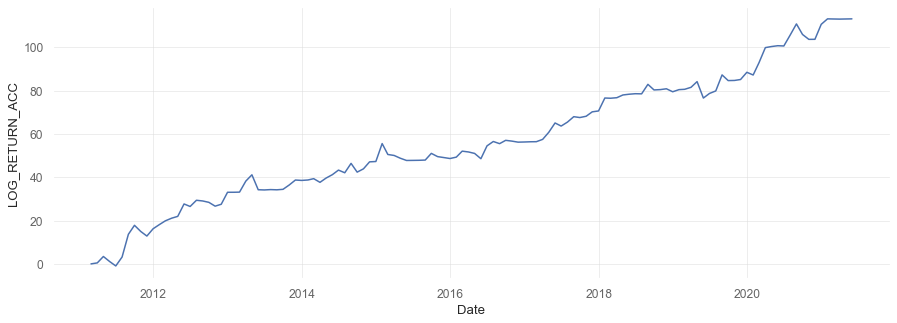

In [20]:
plt.figure(figsize=(15,5))
seaborn.lineplot(data=df_asset, x=df_asset.index, y=df_asset['LOG_RETURN_ACC'])

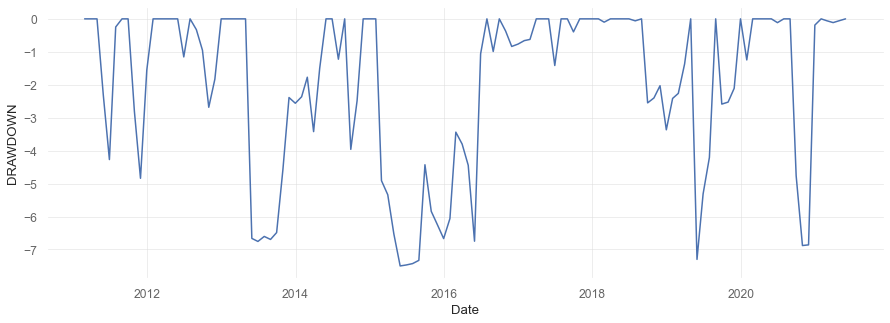

In [21]:
plt.figure(figsize=(15,5))
seaborn.lineplot(data=df_asset, x=df_asset.index, y=df_asset['DRAWDOWN'])

아래 그림의 샤프 비율은 월간 데이터로 구해진 것이라 왜곡되어 있습니다. 환산시킨 1.16이나 Return-Risk Ratio 1.17이 더 믿을 만 합니다.

In [22]:
quantstats.stats.sharpe(df_asset['RETURN'])/math.sqrt(252/12)

1.163734609238336

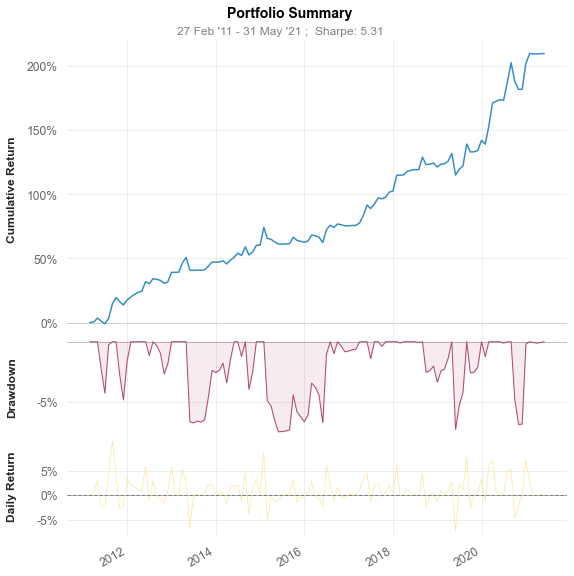

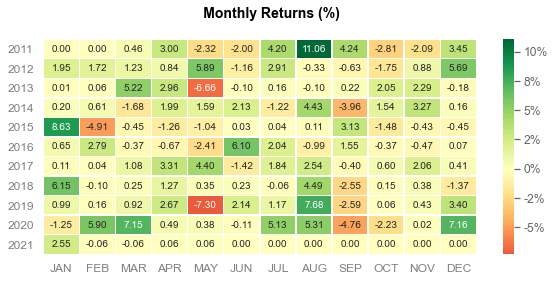

In [23]:
quantstats.reports.plots(df_asset['RETURN']/100, mode='basic')